# Text Summarization

In [18]:
import json
import random

from collections import Counter, namedtuple
import razdel
import pymorphy2

In [9]:
# !wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
# !wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
# !wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [3]:
# !pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy

## EDA 

### Dataset

Посмотрим на то, как устроен датасет

In [13]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r", encoding='utf-8') as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [14]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [15]:
test_records[0]

{'url': 'https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, к

In [16]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [17]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


### Statistics

[Проблемы токенизации](https://natasha.github.io/razdel/)

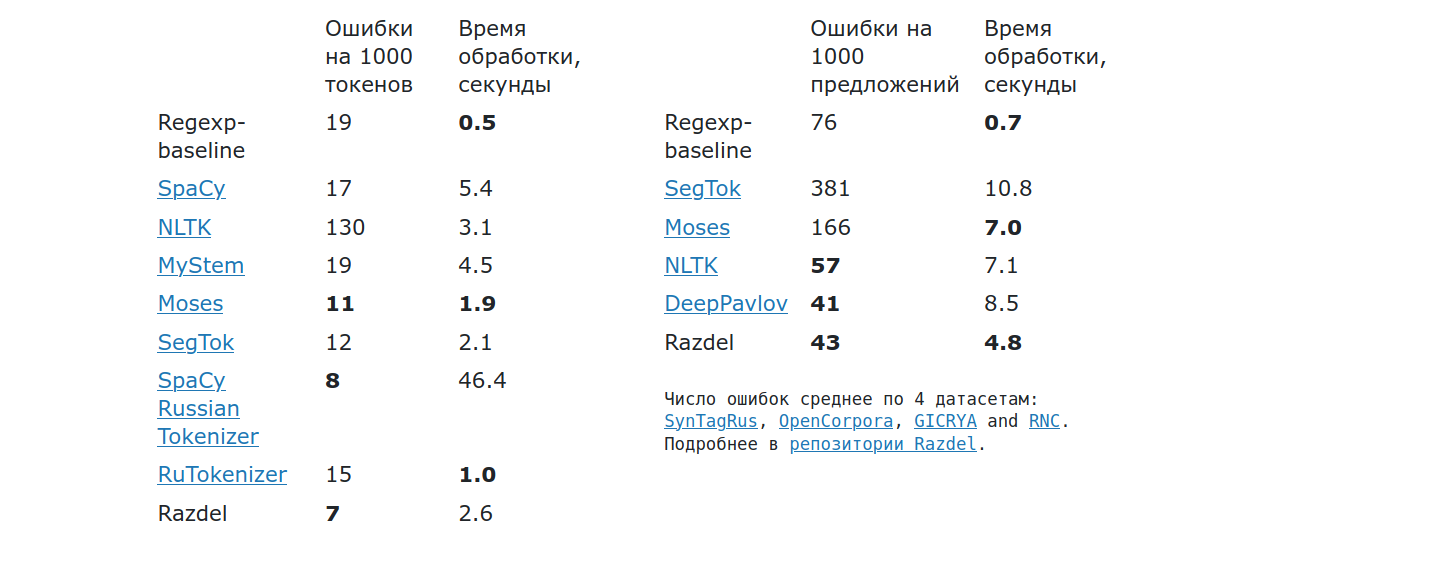

In [19]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [20]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


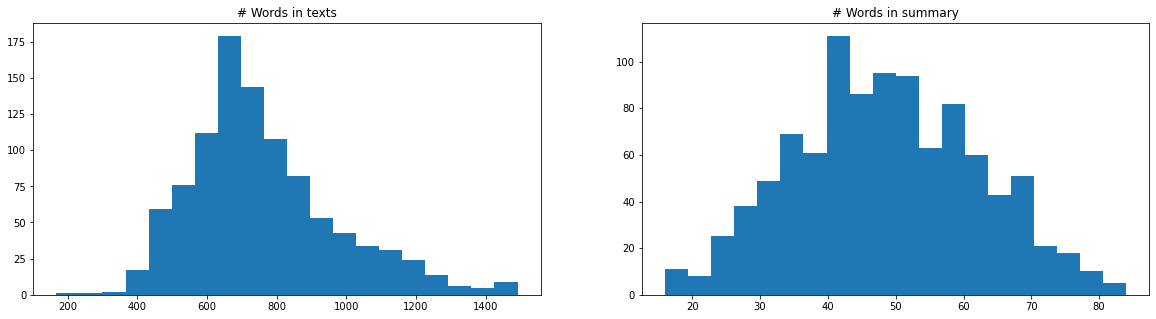

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Lead-3

Первый baseline - первые 3 предложения текста в качестве summary.


В качестве метрик здесь и далее используем BLEU и [ROUGE](https://).<br><br>

* **ROUGE-N** – measures unigram, bigram, trigram and higher order n-gram overlap
* **ROUGE-L** – measures longest matching sequence of words using LCS. An advantage of using LCS is thatit does not require consecutive matches but in-sequence matches that reflect sentence level wordorder. Since it automatically includes longest in-sequence common n-grams, you don’t need apredefined n-gram length.

In [22]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [23]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


## TextRank

https://habr.com/ru/post/455762/

TextRank - unsupervised метод для составления кратких выжимок из текста. 
Описание метода:

1. Сплитим текст по предложениям
2. Считаем "похожесть" предложений между собой
3. Строим граф предложений с взвешенными ребрами
4. С помощью алгоритм PageRank получаем наиболее важные предложения, на основе которых делаем summary.

### Самописный TextRank

In [25]:
from itertools import combinations
import networkx as nx
import pymorphy2
import numpy as np
from tqdm.notebook import tqdm

def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    ''' 
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2)) / (len(words1) + len(words2))
    #return len(words1.intersection(words2)) / (np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank
    
    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Выбираем топ предложений
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]

    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])
    
    num_sents = len(result)
    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary, num_sents

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []
    length_sents = [] 

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, num_sents = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        length_sents.append(num_sents)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    print(f'Mean number of sents in summary: {np.mean(length_sents)}')
    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)

0it [00:00, ?it/s]

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. съемки начнутся уже в ноябре», — указывается в анонсе. от «зенита» до «спартака», — сказал священник. в июне нынешнего года сообщалось, что рпц планирует сделать из сергиева посада «православный ватикан».
BLEU:  0.3508755059541153
ROUGE:  {'rouge-1': {'f': 0.15466400887322831, 'p': 0.16298929023222172, 'r': 0.15602281048791292}, 'rouge-2': {'f': 0.030615979709094604, 'p': 0.031077035455225686, 'r': 0.032019614611385826}, 'rouge-l': {'f': 0.13373567967669006, 'p': 0.14775573752428653, 'r': 0.1

Сделаем TextRank с другой мерой близости предложений: по FastText, ELMo или BERT эмбеддингам

In [26]:
!pip install navec


<img src="https://raw.githubusercontent.com/natasha/natasha-logos/master/navec.svg">
<br>


[Navec](https://github.com/natasha/navec)

In [28]:
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [29]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path) 

In [30]:
from numpy.linalg import norm
def vectorize_sum(words, embeddings):

    embedding_dim = embeddings['example'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')

    num_known_words = 0
    for word in words:
        if word in embeddings:
            num_known_words += 1
            features += embeddings[f'{word}']

    if num_known_words:
        return features / num_known_words
    else: return features

def my_sim(text1, text2, embeddings=navec, kind='cos'):

    v1, v2 = vectorize_sum(text1, embeddings), vectorize_sum(text2, embeddings)
    if np.sum(v1) == 0.0 or np.sum(v2) == 0.0:
        return 0 

    return np.abs(np.dot(v1, v2) / norm(v1) / norm(v2))

In [31]:
calc_text_rank_score(test_records, calc_similarity=my_sim, morph=morph)

0it [00:00, ?it/s]

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. и это что — жизнь, что ли? «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по словам патриарха, им станет тот, кто будет стоять «во главе всемирной паутины».
BLEU:  0.2736838350215274
ROUGE:  {'rouge-1': {'f': 0.15109432683062032, 'p': 0.12445104194115493, 'r': 0.

## Lexrank
* Original paper: https://arxiv.org/pdf/1109.2128.pdf
* lexrank library: https://github.com/crabcamp/lexrank

In [32]:
def calc_method_score(records, predict_func, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)

    calc_scores(references, predictions)

In [33]:
import lexrank
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS


def predict_lex_rank(text, summary, lxr, summary_size=3, threshold=None):
    sentences = [s.text for s in razdel.sentenize(text)]
    prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
    prediction = " ".join(prediction)
    return prediction
    

sentences = [[s.text for s in razdel.sentenize(r["text"])] for r in test_records]
lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
calc_method_score(test_records, lambda x, y: predict_lex_rank(x, y, lxr))

Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: РПЦ же нередко критикует СМИ. Критиковали в РПЦ и популярность футбола – об этом заявлял также Смирнов. В июне нынешнего года сообщалось, что РПЦ планирует сделать из Сергиева Посада «православный Ватикан».
BLEU:  0.3585872220880093
ROUGE:  {'rouge-1': {'f': 0.1866598392888999, 'p': 0.18137864753781832, 'r': 0.2055701577098893}, 'rouge-2': {'f': 0.05775558829470266, 'p': 0.05407660852215697, 'r': 0.06670656927927147}, 'rouge-l': {'f': 0.16173754022433068, 'p': 0.16619633248764337, 'r': 0.18766952121068614}}


## LSA
* One of the original papers: https://www.cs.bham.ac.uk/~pxt/IDA/text_summary.pdf
* sumy library: https://github.com/miso-belica/sumy

In [34]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
import nltk; nltk.download('punkt');


def predict_lsa(text, summary, lsa_summarizer, tokenizer, summary_size=3):
    parser = PlaintextParser.from_string(text, tokenizer)
    predicted_summary = lsa_summarizer(parser.document, summary_size)
    predicted_summary = " ".join([str(s) for s in predicted_summary])
    return predicted_summary

lsa_summarizer = LsaSummarizer()
tokenizer = Tokenizer("russian")
calc_method_score(test_records, lambda x, y: predict_lsa(x, y, lsa_summarizer, tokenizer))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BATMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: Проживи месяц в Ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. Известный миссионер, председатель Синодального отдела МП по взаимодействию с Вооруженными силами и правоохранительными учреждениями протоиерей Дмитрий Смирнов выразил надежду, что проект даст благие результаты. По его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегуманизации» личности, уводя в виртуальную реальность.
BLEU:  0.28862313281779817
ROUGE:  {'rouge-1': {'f': 0.14230080376158924, 'p

### Summa

In [35]:
from summa.summarizer import summarize

def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

## Oracle summary

Для сведения задачи к extractive summarization мы должны выбрать те предложения из оригинального текста, которые наиболее похожи на наше целевое summary по нашим метрикам.

In [38]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [39]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

## RNN

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.DataFrame(train_records)

In [ ]:
df_test = pd.DataFrame(test_records)
df_test[:3]

,url,text,title,summary,date
0,https://www.gazeta.ru/science/2020/02/14_a_129...,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA","В NASA назвали четыре миссии в дальний космос,...",2020-02-14 16:39:11
1,https://www.gazeta.ru/social/2020/02/28/129806...,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,25 и 26 февраля в Кремлевском дворце съездов п...,2020-02-28 10:44:13
2,https://www.gazeta.ru/politics/2019/11/07_a_12...,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,В Белоруссии в день годовщины Октябрьской рево...,2019-11-07 19:55:08


In [ ]:
df_train[:5]

,url,text,title,summary,date
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14
3,https://www.gazeta.ru/business/2013/06/21/5388...,Как повлияло вступление в ВТО на конкурентносп...,«С последних традиционно «отжимают» больше»,Мнения предпринимателей по поводу вступления в...,2013-06-21 17:43:50
4,https://www.gazeta.ru/culture/2014/12/27/a_636...,К третьему сезону «Голос» на Первом канале ста...,Третий «Голос» за Градского,На Первом канале завершился третий сезон шоу «...,2014-12-27 01:10:01


In [ ]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_train['summary_clean'][:5]

0    BOS В 2011 году из России уйдет $80 млрд, счит...
1    BOS Юлия Соловьева, экс-директор холдинга «Про...
2    BOS Суд арестовал на два месяца четверых экс-ч...
3    BOS Мнения предпринимателей по поводу вступлен...
4    BOS На Первом канале завершился третий сезон ш...
Name: summary_clean, dtype: object

In [ ]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200

df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_len_text = 700
max_len_sum = 70

In [ ]:
#tok_text = Tokenizer(oov_token='UNK')
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [ ]:
text_vocab_size=len(tok_text.word_index)+1

padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [ ]:
#tok_sum = Tokenizer(oov_token='UNK')
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])

sum_vocab_size=len(tok_sum.word_index)+1

padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [ ]:
padded_x_train_sum.shape

(1000, 70)

In [ ]:
reverse_text_index=tok_text.index_word
reverse_sum_index=tok_sum.index_word
sum_wordindex=tok_sum.word_index

### Model

In [ ]:
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

In [ ]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 200)     17664000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 700, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=10,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=16)

Epoch 1/10
63/63 [==============================] - 474s 8s/step - loss: 5.9352 - accuracy: 0.3842 - val_loss: 4.1845 - val_accuracy: 0.5136
Epoch 2/10
63/63 [==============================] - 471s 7s/step - loss: 5.2514 - accuracy: 0.4008 - val_loss: 3.9034 - val_accuracy: 0.5278
Epoch 3/10
63/63 [==============================] - 472s 7s/step - loss: 5.0898 - accuracy: 0.4118 - val_loss: 3.8779 - val_accuracy: 0.5309
Epoch 4/10
63/63 [==============================] - 468s 7s/step - loss: 4.9923 - accuracy: 0.4151 - val_loss: 3.8889 - val_accuracy: 0.5314
Epoch 5/10
63/63 [==============================] - 468s 7s/step - loss: 4.9407 - accuracy: 0.4141 - val_loss: 3.8956 - val_accuracy: 0.5317
Epoch 6/10
63/63 [==============================] - 470s 7s/step - loss: 4.8538 - accuracy: 0.4154 - val_loss: 3.9152 - val_accuracy: 0.5300
Epoch 7/10
63/63 [==============================] - 469s 7s/step - loss: 4.7675 - accuracy: 0.4169 - val_loss: 3.9526 - val_accuracy: 0.5260
Epoch 8/10
63

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString


In [ ]:
for i in range(0, 3):
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:",seq2summary(padded_x_test_sum[i]))

    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

Original summary: в nasa назвали четыре миссии в космос которые в этом могут быть американцами среди них — две миссии по полет к и к 
Predicted summary:  в москве в москве в участием главного в матче и матче и матче и два и словам и словам и словам и словам и словам и словам а и словам а а а


Original summary: 25 и 26 февраля в праздновали — новый год центр российского и один из регионов страны где новый год официально дважды 
Predicted summary:  в москве в москве в участием главного в матче и матче и матче и два и словам и два и словам и словам и словам и словам и словам и словам а и илья


Original summary: в белоруссии в день революции выбрали членов палаты парламента сегодняшнее голосование — основной части процесса через десять дней в республике пройдут выборы в палату представителей которые станут для александра лукашенко ведь за ними будут следить на западе 
Predicted summary:  в москве в москве в участием главного в матче и матче и матче и два и словам и два и словам и словам 

## Attention

In [ ]:
from tensorflow.keras.layers import GRU, AdditiveAttention

In [ ]:
df_train['text'],
df_train['summary_clean']

0       BOS В 2011 году из России уйдет $80 млрд, счит...
1       BOS Юлия Соловьева, экс-директор холдинга «Про...
2       BOS Суд арестовал на два месяца четверых экс-ч...
3       BOS Мнения предпринимателей по поводу вступлен...
4       BOS На Первом канале завершился третий сезон ш...
                              ...                        
1995    BOS Практически половина американских военносл...
1996    BOS Семь человек, находившиеся в салоне «Жигул...
1997    BOS Участники детской Таврической ассамблеи вм...
1998    BOS Дмитрий Медведев едет с однодневным визито...
1999    BOS Мать супруги Александра Кержакова Миланы р...
Name: summary_clean, Length: 2000, dtype: object

In [ ]:
BUFFER_SIZE = len(padded_x_train)
BATCH_SIZE = 32
steps_per_epoch = len(padded_x_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, padded_x_train_sum)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 700]), TensorShape([32, 70]))

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru1(x, initial_state = hidden)
        output, state = self.gru2(output, initial_state = state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, x, query, value):
        # enc_output shape == (batch_size, max_length, hidden_size)
        #attention_weights = self.attention([ tf.expand_dims(query, 1), value,])
        context_vector = self.attention([tf.expand_dims(query, 1), value,])
        #context_vector = tf.squeeze(context_vector)


        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [ ]:
latent_dim = 300
embedding_dim=200

In [ ]:
encoder = Encoder(text_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
decoder = Decoder(sum_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([sum_wordindex['bos']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
checkpoint_dir = './training_summ_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.4686
Epoch 1 Batch 10 Loss 6.1616
Epoch 1 Batch 20 Loss 5.7005
Epoch 1 Batch 30 Loss 5.9251
Epoch 1 Batch 40 Loss 6.3801
Epoch 1 Batch 50 Loss 5.5302
Epoch 1 Batch 60 Loss 5.7837
Epoch 1 Batch 70 Loss 5.4195
Epoch 1 Batch 80 Loss 5.3535
Epoch 1 Batch 90 Loss 5.3947
Epoch 1 Batch 100 Loss 6.0000
Epoch 1 Batch 110 Loss 5.0411
Epoch 1 Batch 120 Loss 5.4153
Epoch 1 Batch 130 Loss 5.2158
Epoch 1 Batch 140 Loss 5.3665
Epoch 1 Batch 150 Loss 5.3218
Epoch 1 Batch 160 Loss 5.4727
Epoch 1 Batch 170 Loss 5.8124
Epoch 1 Batch 180 Loss 5.1786
Epoch 1 Batch 190 Loss 5.7869
Epoch 1 Batch 200 Loss 5.3352
Epoch 1 Batch 210 Loss 5.6502
Epoch 1 Batch 220 Loss 5.5291
Epoch 1 Batch 230 Loss 5.2073
Epoch 1 Batch 240 Loss 5.8169
Epoch 1 Batch 250 Loss 5.2287
Epoch 1 Batch 260 Loss 5.3542
Epoch 1 Batch 270 Loss 6.1748
Epoch 1 Batch 280 Loss 5.6003
Epoch 1 Batch 290 Loss 5.3365
Epoch 1 Batch 300 Loss 4.9135
Epoch 1 Batch 310 Loss 5.0006
Epoch 1 Loss 5.5587
Time taken for 1 epoch 259.9202

Epoch 9 Batch 30 Loss 3.9033
Epoch 9 Batch 40 Loss 4.0156
Epoch 9 Batch 50 Loss 4.1288
Epoch 9 Batch 60 Loss 3.9326
Epoch 9 Batch 70 Loss 4.0765
Epoch 9 Batch 80 Loss 4.0113
Epoch 9 Batch 90 Loss 4.1021
Epoch 9 Batch 100 Loss 4.0490
Epoch 9 Batch 110 Loss 4.1429
Epoch 9 Batch 120 Loss 4.0896
Epoch 9 Batch 130 Loss 4.0664
Epoch 9 Batch 140 Loss 4.0707
Epoch 9 Batch 150 Loss 3.4949
Epoch 9 Batch 160 Loss 3.9992
Epoch 9 Batch 170 Loss 4.0464
Epoch 9 Batch 180 Loss 3.8512
Epoch 9 Batch 190 Loss 3.8779
Epoch 9 Batch 200 Loss 4.0536
Epoch 9 Batch 210 Loss 4.3218
Epoch 9 Batch 220 Loss 3.9598
Epoch 9 Batch 230 Loss 4.3709
Epoch 9 Batch 240 Loss 4.1013
Epoch 9 Batch 250 Loss 4.5352
Epoch 9 Batch 260 Loss 4.1095
Epoch 9 Batch 270 Loss 4.2966
Epoch 9 Batch 280 Loss 4.0670
Epoch 9 Batch 290 Loss 4.4197
Epoch 9 Batch 300 Loss 4.4007
Epoch 9 Batch 310 Loss 4.2980
Epoch 9 Loss 4.0495
Time taken for 1 epoch 183.70963263511658 sec

Epoch 10 Batch 0 Loss 3.9541
Epoch 10 Batch 10 Loss 3.5985
Epoch 10 Ba

Epoch 16 Loss 2.8600
Time taken for 1 epoch 189.1212432384491 sec

Epoch 17 Batch 0 Loss 2.6195
Epoch 17 Batch 10 Loss 2.5559
Epoch 17 Batch 20 Loss 2.8058
Epoch 17 Batch 30 Loss 2.6822
Epoch 17 Batch 40 Loss 2.5620
Epoch 17 Batch 50 Loss 2.7405
Epoch 17 Batch 60 Loss 2.5119
Epoch 17 Batch 70 Loss 2.7019
Epoch 17 Batch 80 Loss 2.7369
Epoch 17 Batch 90 Loss 2.6679
Epoch 17 Batch 100 Loss 2.5201
Epoch 17 Batch 110 Loss 2.6091
Epoch 17 Batch 120 Loss 3.0296
Epoch 17 Batch 130 Loss 2.5817
Epoch 17 Batch 140 Loss 2.5925
Epoch 17 Batch 150 Loss 2.8036
Epoch 17 Batch 160 Loss 2.7484
Epoch 17 Batch 170 Loss 2.8419
Epoch 17 Batch 180 Loss 2.6264
Epoch 17 Batch 190 Loss 2.6330
Epoch 17 Batch 200 Loss 2.7134
Epoch 17 Batch 210 Loss 2.6531
Epoch 17 Batch 220 Loss 2.5940
Epoch 17 Batch 230 Loss 2.5851
Epoch 17 Batch 240 Loss 2.9581
Epoch 17 Batch 250 Loss 2.9199
Epoch 17 Batch 260 Loss 2.9517
Epoch 17 Batch 270 Loss 2.6409
Epoch 17 Batch 280 Loss 2.6051
Epoch 17 Batch 290 Loss 2.8191
Epoch 17 Batch

Epoch 24 Batch 260 Loss 1.7921
Epoch 24 Batch 270 Loss 1.9700
Epoch 24 Batch 280 Loss 1.9187
Epoch 24 Batch 290 Loss 1.9514
Epoch 24 Batch 300 Loss 1.9452
Epoch 24 Batch 310 Loss 2.1908
Epoch 24 Loss 1.9463
Time taken for 1 epoch 188.55324053764343 sec

Epoch 25 Batch 0 Loss 1.7217
Epoch 25 Batch 10 Loss 1.5923
Epoch 25 Batch 20 Loss 1.8098
Epoch 25 Batch 30 Loss 1.5959
Epoch 25 Batch 40 Loss 1.9233
Epoch 25 Batch 50 Loss 1.9646
Epoch 25 Batch 60 Loss 1.8019
Epoch 25 Batch 70 Loss 1.7614
Epoch 25 Batch 80 Loss 1.8318
Epoch 25 Batch 90 Loss 1.7258
Epoch 25 Batch 100 Loss 2.0347
Epoch 25 Batch 110 Loss 1.9343
Epoch 25 Batch 120 Loss 2.0007
Epoch 25 Batch 130 Loss 1.9353
Epoch 25 Batch 140 Loss 1.8457
Epoch 25 Batch 150 Loss 2.1843
Epoch 25 Batch 160 Loss 1.9545
Epoch 25 Batch 170 Loss 1.6847
Epoch 25 Batch 180 Loss 1.9835
Epoch 25 Batch 190 Loss 1.9891
Epoch 25 Batch 200 Loss 1.7472
Epoch 25 Batch 210 Loss 1.8690
Epoch 25 Batch 220 Loss 1.9279
Epoch 25 Batch 230 Loss 1.8221
Epoch 25 Batc

Epoch 32 Batch 200 Loss 1.2976
Epoch 32 Batch 210 Loss 1.4730
Epoch 32 Batch 220 Loss 1.5277
Epoch 32 Batch 230 Loss 1.4541
Epoch 32 Batch 240 Loss 1.6235
Epoch 32 Batch 250 Loss 1.5794
Epoch 32 Batch 260 Loss 1.4106
Epoch 32 Batch 270 Loss 1.6942
Epoch 32 Batch 280 Loss 1.4999
Epoch 32 Batch 290 Loss 1.6792
Epoch 32 Batch 300 Loss 1.5968
Epoch 32 Batch 310 Loss 1.4663
Epoch 32 Loss 1.4355
Time taken for 1 epoch 188.34524059295654 sec

Epoch 33 Batch 0 Loss 1.4321
Epoch 33 Batch 10 Loss 1.4006
Epoch 33 Batch 20 Loss 1.2435
Epoch 33 Batch 30 Loss 1.1409
Epoch 33 Batch 40 Loss 1.2753
Epoch 33 Batch 50 Loss 1.3926
Epoch 33 Batch 60 Loss 1.2482
Epoch 33 Batch 70 Loss 1.3051
Epoch 33 Batch 80 Loss 1.3005
Epoch 33 Batch 90 Loss 1.3770
Epoch 33 Batch 100 Loss 1.3120
Epoch 33 Batch 110 Loss 1.2599
Epoch 33 Batch 120 Loss 1.1296
Epoch 33 Batch 130 Loss 1.4739
Epoch 33 Batch 140 Loss 1.3998
Epoch 33 Batch 150 Loss 1.4535
Epoch 33 Batch 160 Loss 1.4483
Epoch 33 Batch 170 Loss 1.3252
Epoch 33 Batc

Epoch 40 Batch 140 Loss 1.1028
Epoch 40 Batch 150 Loss 1.0430
Epoch 40 Batch 160 Loss 1.0193
Epoch 40 Batch 170 Loss 1.0440
Epoch 40 Batch 180 Loss 1.0376
Epoch 40 Batch 190 Loss 1.0222
Epoch 40 Batch 200 Loss 1.0614
Epoch 40 Batch 210 Loss 1.1881
Epoch 40 Batch 220 Loss 1.0612
Epoch 40 Batch 230 Loss 1.1463
Epoch 40 Batch 240 Loss 0.9557
Epoch 40 Batch 250 Loss 1.0499
Epoch 40 Batch 260 Loss 1.2317
Epoch 40 Batch 270 Loss 1.2231
Epoch 40 Batch 280 Loss 1.2076
Epoch 40 Batch 290 Loss 1.1343
Epoch 40 Batch 300 Loss 1.1838
Epoch 40 Batch 310 Loss 1.1196
Epoch 40 Loss 1.0718
Time taken for 1 epoch 191.16232657432556 sec

Epoch 41 Batch 0 Loss 0.8338
Epoch 41 Batch 10 Loss 1.0525
Epoch 41 Batch 20 Loss 1.1315
Epoch 41 Batch 30 Loss 0.9165
Epoch 41 Batch 40 Loss 0.9195
Epoch 41 Batch 50 Loss 1.0533
Epoch 41 Batch 60 Loss 0.9572
Epoch 41 Batch 70 Loss 0.9096
Epoch 41 Batch 80 Loss 0.9867
Epoch 41 Batch 90 Loss 1.0727
Epoch 41 Batch 100 Loss 1.0851
Epoch 41 Batch 110 Loss 0.9690
Epoch 41 Batc

Epoch 48 Batch 80 Loss 0.8919
Epoch 48 Batch 90 Loss 0.8557
Epoch 48 Batch 100 Loss 0.7628
Epoch 48 Batch 110 Loss 0.6853
Epoch 48 Batch 120 Loss 0.8365
Epoch 48 Batch 130 Loss 0.8101
Epoch 48 Batch 140 Loss 0.7623
Epoch 48 Batch 150 Loss 0.8190
Epoch 48 Batch 160 Loss 0.8313
Epoch 48 Batch 170 Loss 0.8228
Epoch 48 Batch 180 Loss 0.8798
Epoch 48 Batch 190 Loss 0.7299
Epoch 48 Batch 200 Loss 0.7202
Epoch 48 Batch 210 Loss 0.7296
Epoch 48 Batch 220 Loss 0.7246
Epoch 48 Batch 230 Loss 0.8071
Epoch 48 Batch 240 Loss 0.8651
Epoch 48 Batch 250 Loss 0.7588
Epoch 48 Batch 260 Loss 0.9402
Epoch 48 Batch 270 Loss 0.8466
Epoch 48 Batch 280 Loss 0.8384
Epoch 48 Batch 290 Loss 0.7372
Epoch 48 Batch 300 Loss 0.6867
Epoch 48 Batch 310 Loss 0.8316
Epoch 48 Loss 0.8073
Time taken for 1 epoch 187.12636375427246 sec

Epoch 49 Batch 0 Loss 0.8367
Epoch 49 Batch 10 Loss 0.6974
Epoch 49 Batch 20 Loss 0.7081
Epoch 49 Batch 30 Loss 0.8363
Epoch 49 Batch 40 Loss 0.6643
Epoch 49 Batch 50 Loss 0.6882
Epoch 49 Ba

Epoch 56 Batch 20 Loss 0.6062
Epoch 56 Batch 30 Loss 0.5256
Epoch 56 Batch 40 Loss 0.7785
Epoch 56 Batch 50 Loss 0.5516
Epoch 56 Batch 60 Loss 0.5534
Epoch 56 Batch 70 Loss 0.5795
Epoch 56 Batch 80 Loss 0.5935
Epoch 56 Batch 90 Loss 0.6038
Epoch 56 Batch 100 Loss 0.6442
Epoch 56 Batch 110 Loss 0.6282
Epoch 56 Batch 120 Loss 0.6606
Epoch 56 Batch 130 Loss 0.5718
Epoch 56 Batch 140 Loss 0.6078
Epoch 56 Batch 150 Loss 0.6951
Epoch 56 Batch 160 Loss 0.6602
Epoch 56 Batch 170 Loss 0.5924
Epoch 56 Batch 180 Loss 0.6188
Epoch 56 Batch 190 Loss 0.6241
Epoch 56 Batch 200 Loss 0.7261
Epoch 56 Batch 210 Loss 0.6406
Epoch 56 Batch 220 Loss 0.5090
Epoch 56 Batch 230 Loss 0.7041
Epoch 56 Batch 240 Loss 0.6306
Epoch 56 Batch 250 Loss 0.6720
Epoch 56 Batch 260 Loss 0.6537
Epoch 56 Batch 270 Loss 0.6871
Epoch 56 Batch 280 Loss 0.6395
Epoch 56 Batch 290 Loss 0.6602
Epoch 56 Batch 300 Loss 0.6802
Epoch 56 Batch 310 Loss 0.5796
Epoch 56 Loss 0.6144
Time taken for 1 epoch 186.7829966545105 sec

Epoch 57 Ba

Epoch 63 Batch 300 Loss 0.5059
Epoch 63 Batch 310 Loss 0.4934
Epoch 63 Loss 0.4892
Time taken for 1 epoch 188.53474378585815 sec

Epoch 64 Batch 0 Loss 0.4731
Epoch 64 Batch 10 Loss 0.4397
Epoch 64 Batch 20 Loss 0.5271
Epoch 64 Batch 30 Loss 0.4387
Epoch 64 Batch 40 Loss 0.4672
Epoch 64 Batch 50 Loss 0.4749
Epoch 64 Batch 60 Loss 0.5063
Epoch 64 Batch 70 Loss 0.4323
Epoch 64 Batch 80 Loss 0.5136
Epoch 64 Batch 90 Loss 0.4582
Epoch 64 Batch 100 Loss 0.4819
Epoch 64 Batch 110 Loss 0.4136
Epoch 64 Batch 120 Loss 0.4090
Epoch 64 Batch 130 Loss 0.4441
Epoch 64 Batch 140 Loss 0.4240
Epoch 64 Batch 150 Loss 0.4298
Epoch 64 Batch 160 Loss 0.4983
Epoch 64 Batch 170 Loss 0.5326
Epoch 64 Batch 180 Loss 0.4638
Epoch 64 Batch 190 Loss 0.4611
Epoch 64 Batch 200 Loss 0.4276
Epoch 64 Batch 210 Loss 0.5167
Epoch 64 Batch 220 Loss 0.4583
Epoch 64 Batch 230 Loss 0.5173
Epoch 64 Batch 240 Loss 0.4842
Epoch 64 Batch 250 Loss 0.4829
Epoch 64 Batch 260 Loss 0.4433
Epoch 64 Batch 270 Loss 0.5768
Epoch 64 Batc

Epoch 71 Batch 240 Loss 0.4495
Epoch 71 Batch 250 Loss 0.4068
Epoch 71 Batch 260 Loss 0.3993
Epoch 71 Batch 270 Loss 0.3935
Epoch 71 Batch 280 Loss 0.4466
Epoch 71 Batch 290 Loss 0.4009
Epoch 71 Batch 300 Loss 0.3494
Epoch 71 Batch 310 Loss 0.3434
Epoch 71 Loss 0.3755
Time taken for 1 epoch 188.50063848495483 sec

Epoch 72 Batch 0 Loss 0.2873
Epoch 72 Batch 10 Loss 0.2799
Epoch 72 Batch 20 Loss 0.3245
Epoch 72 Batch 30 Loss 0.2926
Epoch 72 Batch 40 Loss 0.3697
Epoch 72 Batch 50 Loss 0.3355
Epoch 72 Batch 60 Loss 0.3385
Epoch 72 Batch 70 Loss 0.3149
Epoch 72 Batch 80 Loss 0.4300
Epoch 72 Batch 90 Loss 0.3338
Epoch 72 Batch 100 Loss 0.3283
Epoch 72 Batch 110 Loss 0.3578
Epoch 72 Batch 120 Loss 0.3547
Epoch 72 Batch 130 Loss 0.3767
Epoch 72 Batch 140 Loss 0.3145
Epoch 72 Batch 150 Loss 0.3425
Epoch 72 Batch 160 Loss 0.3710
Epoch 72 Batch 170 Loss 0.4035
Epoch 72 Batch 180 Loss 0.3358
Epoch 72 Batch 190 Loss 0.4629
Epoch 72 Batch 200 Loss 0.3567
Epoch 72 Batch 210 Loss 0.4228
Epoch 72 Batc

Epoch 79 Batch 180 Loss 0.3300
Epoch 79 Batch 190 Loss 0.2649
Epoch 79 Batch 200 Loss 0.3135
Epoch 79 Batch 210 Loss 0.2969
Epoch 79 Batch 220 Loss 0.2846
Epoch 79 Batch 230 Loss 0.2560
Epoch 79 Batch 240 Loss 0.3474
Epoch 79 Batch 250 Loss 0.2699
Epoch 79 Batch 260 Loss 0.3852
Epoch 79 Batch 270 Loss 0.2124
Epoch 79 Batch 280 Loss 0.2530
Epoch 79 Batch 290 Loss 0.2877
Epoch 79 Batch 300 Loss 0.3444
Epoch 79 Batch 310 Loss 0.3595
Epoch 79 Loss 0.2884
Time taken for 1 epoch 188.77244448661804 sec

Epoch 80 Batch 0 Loss 0.2721
Epoch 80 Batch 10 Loss 0.2697
Epoch 80 Batch 20 Loss 0.3205
Epoch 80 Batch 30 Loss 0.2937
Epoch 80 Batch 40 Loss 0.2858
Epoch 80 Batch 50 Loss 0.2992
Epoch 80 Batch 60 Loss 0.2570
Epoch 80 Batch 70 Loss 0.2534
Epoch 80 Batch 80 Loss 0.2813
Epoch 80 Batch 90 Loss 0.2636
Epoch 80 Batch 100 Loss 0.3083
Epoch 80 Batch 110 Loss 0.2255
Epoch 80 Batch 120 Loss 0.3354
Epoch 80 Batch 130 Loss 0.3207
Epoch 80 Batch 140 Loss 0.2769
Epoch 80 Batch 150 Loss 0.2417
Epoch 80 Batc

Epoch 87 Batch 120 Loss 0.1910
Epoch 87 Batch 130 Loss 0.2619
Epoch 87 Batch 140 Loss 0.2279
Epoch 87 Batch 150 Loss 0.2085
Epoch 87 Batch 160 Loss 0.2200
Epoch 87 Batch 170 Loss 0.2126
Epoch 87 Batch 180 Loss 0.2521
Epoch 87 Batch 190 Loss 0.2273
Epoch 87 Batch 200 Loss 0.2757
Epoch 87 Batch 210 Loss 0.2142
Epoch 87 Batch 220 Loss 0.2399
Epoch 87 Batch 230 Loss 0.1904
Epoch 87 Batch 240 Loss 0.2369
Epoch 87 Batch 250 Loss 0.1809
Epoch 87 Batch 260 Loss 0.2672
Epoch 87 Batch 270 Loss 0.2322
Epoch 87 Batch 280 Loss 0.2329
Epoch 87 Batch 290 Loss 0.1805
Epoch 87 Batch 300 Loss 0.2076
Epoch 87 Batch 310 Loss 0.2292
Epoch 87 Loss 0.2191
Time taken for 1 epoch 187.90514969825745 sec

Epoch 88 Batch 0 Loss 0.1673
Epoch 88 Batch 10 Loss 0.2846
Epoch 88 Batch 20 Loss 0.1800
Epoch 88 Batch 30 Loss 0.1909
Epoch 88 Batch 40 Loss 0.2011
Epoch 88 Batch 50 Loss 0.2445
Epoch 88 Batch 60 Loss 0.1864
Epoch 88 Batch 70 Loss 0.2276
Epoch 88 Batch 80 Loss 0.2389
Epoch 88 Batch 90 Loss 0.1608
Epoch 88 Batc

Epoch 95 Batch 60 Loss 0.1330
Epoch 95 Batch 70 Loss 0.1368
Epoch 95 Batch 80 Loss 0.1699
Epoch 95 Batch 90 Loss 0.1824
Epoch 95 Batch 100 Loss 0.2001
Epoch 95 Batch 110 Loss 0.1536
Epoch 95 Batch 120 Loss 0.1982
Epoch 95 Batch 130 Loss 0.1287
Epoch 95 Batch 140 Loss 0.1305
Epoch 95 Batch 150 Loss 0.1925
Epoch 95 Batch 160 Loss 0.1537
Epoch 95 Batch 170 Loss 0.1550
Epoch 95 Batch 180 Loss 0.1631
Epoch 95 Batch 190 Loss 0.1776
Epoch 95 Batch 200 Loss 0.1664
Epoch 95 Batch 210 Loss 0.1331
Epoch 95 Batch 220 Loss 0.1922
Epoch 95 Batch 230 Loss 0.1957
Epoch 95 Batch 240 Loss 0.1494
Epoch 95 Batch 250 Loss 0.1224
Epoch 95 Batch 260 Loss 0.1548
Epoch 95 Batch 270 Loss 0.1708
Epoch 95 Batch 280 Loss 0.1816
Epoch 95 Batch 290 Loss 0.1742
Epoch 95 Batch 300 Loss 0.1358
Epoch 95 Batch 310 Loss 0.1941
Epoch 95 Loss 0.1632
Time taken for 1 epoch 189.53813242912292 sec

Epoch 96 Batch 0 Loss 0.1592
Epoch 96 Batch 10 Loss 0.1908
Epoch 96 Batch 20 Loss 0.1421
Epoch 96 Batch 30 Loss 0.1322
Epoch 96 Ba

In [ ]:
tok_sum.word_index

{'в': 1,
 'bos': 2,
 'eos': 3,
 'и': 4,
 'на': 5,
 'с': 6,
 'не': 7,
 'по': 8,
 'что': 9,
 'за': 10,
 'из': 11,
 '—': 12,
 'а': 13,
 'россии': 14,
 'к': 15,
 'о': 16,
 'его': 17,
 'от': 18,
 'для': 19,
 'сша': 20,
 'после': 21,
 'но': 22,
 'как': 23,
 'может': 24,
 'он': 25,
 'года': 26,
 'у': 27,
 'будет': 28,
 'до': 29,
 'это': 30,
 'уже': 31,
 'эксперты': 32,
 'также': 33,
 'во': 34,
 'при': 35,
 'лет': 36,
 'году': 37,
 'который': 38,
 'президента': 39,
 'заявил': 40,
 'ранее': 41,
 'со': 42,
 'однако': 43,
 'время': 44,
 'под': 45,
 'только': 46,
 'президент': 47,
 'более': 48,
 'матче': 49,
 'словам': 50,
 'еще': 51,
 'против': 52,
 'ее': 53,
 'мира': 54,
 'которые': 55,
 'этом': 56,
 'был': 57,
 'суд': 58,
 'все': 59,
 '1': 60,
 'власти': 61,
 'их': 62,
 'страны': 63,
 'украины': 64,
 'об': 65,
 'млн': 66,
 'над': 67,
 'могут': 68,
 'российский': 69,
 'того': 70,
 'владимир': 71,
 '–': 72,
 'считают': 73,
 'москве': 74,
 'пока': 75,
 'экс': 76,
 'лиги': 77,
 'так': 78,
 'чтобы':

In [ ]:
def evaluate(sentence):
    inputs = [tok_text.word_index[i] for i in sentence.split(' ') if i !='']
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_len_text,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tok_sum.word_index['bos']], 0)

    for t in range(max_len_sum):
        predictions, dec_hidden = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)



        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tok_sum.index_word[predicted_id] + ' '

        if tok_sum.index_word[predicted_id] == 'eos':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [ ]:
def summ(sentence):
    result, sentence = evaluate(sentence)

    return result

In [ ]:
for i in range(3, 6):
    text2 = seq2text(padded_x_test[i])
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:", seq2summary(padded_x_test_sum[i]))
    print("Predicted summary: ", summ(text2.strip()))
    print("\n")

Original summary: народная артистка рсфср надежда в интервью откровенно рассказала о своей жизни в частности певица объяснила почему ее гражданский муж переживает по поводу об их отношениях а также не смогла сдержать слез говоря о смерти младшего брата 
Predicted summary:  супруга своего окружения и телеведущая ксения собчак извинилась перед комиссией действующий адвокат журналиста в киеве по его словам актрисы агаты муцениеце мариам халилова заявила что предпосылки к поклонникам в киеве по его словам актрисы агаты муцениеце мариам халилова заявила что предпосылки к поклонникам в киеве по его словам актрисы агаты муцениеце мариам халилова заявила что предпосылки к поклонникам в киеве по его словам актрисы агаты муцениеце мариам халилова заявила что 


Original summary: украина не должна выплачивать пенсии жителям днр и лнр поскольку они могут поддерживать россию заявила депутат верховной рады от партии «слуга народа» елизавета она выступила против закона о праве на получение пособий от